In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import os
import json
import saliency.core.visualization as vis
from saliency.core.base import *
import ig2
from ig2 import REP_LAYER_VALUES, REP_DISTANCE_GRADIENTS
import cv2
import random

import clip

In [2]:
data_transform = transforms.Compose(
    [
        transforms.Resize(
            (224,224), interpolation=transforms.InterpolationMode.BICUBIC
        ),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

def transform_vision_data(image):
    """
    Input:
        image: An image read by opencv [w,h,c]
    Output:
        image: After preproccessing, is a tensor [c,w,h]
    """
    image = Image.fromarray(image)
    image = data_transform(image)
    return image

def preprocess_input(images):
    """
    Input:
        image: An image read by opencv [b,w,h,c]
    Output:
        outputs: After preproccessing, is a tensor [c,w,h]
    """
    outputs = []
    for image in images:
        image = Image.fromarray(np.uint8(image))
        image = data_transform(image)
        outputs.append(image)
    return torch.stack(outputs).requires_grad_(True)

In [14]:
def imshow(img):
    """
    Visualizing images inside jupyter notebook
    """
    plt.axis('off')
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# transform image to rgb
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

In [3]:
class CLIPModel_Super(torch.nn.Module):
    def __init__(self, 
                 type="ViT-L/14", 
                 download_root=None,
                 device = "cuda"):
        super().__init__()
        self.device = device
        self.model, _ = clip.load(type, device=self.device, download_root=download_root)
        
    def equip_semantic_modal(self, modal_list):
        text = clip.tokenize(modal_list).to(self.device)
        
        with torch.no_grad():
            self.text_features = self.model.encode_text(text)
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            
    def forward(self, vision_inputs):
        
        # with torch.no_grad():
        image_features = self.model.encode_image(vision_inputs)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        scores = (image_features @ self.text_features.T).softmax(dim=-1)
        return scores.float()

In [5]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"

vis_model = CLIPModel_Super("ViT-L/14", download_root="../../.checkpoints/CLIP")
vis_model.eval()
vis_model.to(device)

print("ok")

ok


In [7]:
semantic_path = "../../ckpt/semantic_features/clip_vitl_imagenet_zeroweights.pt"
if os.path.exists(semantic_path):
    semantic_feature = torch.load(semantic_path, map_location="cpu")
    semantic_feature = semantic_feature.to(device)

vis_model.text_features = semantic_feature

In [9]:
rep_layer = vis_model.model.visual.ln_post
rep_layer_outputs = {}

In [10]:
# Hook for representation
def rep_layer_forward(m, i, o):
    rep_layer_outputs[REP_LAYER_VALUES] = i[0]
forward_hook = rep_layer.register_forward_hook(rep_layer_forward)

class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = preprocess_input(images)
    target_class_idx =  call_model_args[class_idx_str]
    logits = vis_model(images.to(device))
    if INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = logits[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.cpu().detach().numpy()
        return {INPUT_OUTPUT_GRADIENTS: gradients}

    elif REP_LAYER_VALUES in expected_keys:        
        return rep_layer_outputs

    # Gradient descent-based search for GradPath
    elif REP_DISTANCE_GRADIENTS in expected_keys:
        loss_fn = torch.nn.MSELoss()         
        baseline_conv = call_model_args['layer_baseline']
        input_conv = rep_layer_outputs[REP_LAYER_VALUES]
        
        loss = -1 * loss_fn(input_conv, baseline_conv)
        loss.backward()
        grads = images.grad.data
        grads = torch.movedim(grads, 1, 3)
        gradients = grads.cpu().detach().numpy()
        return {REP_DISTANCE_GRADIENTS: gradients,
                'loss':loss}

In [11]:
im = cv2.imread("../../examples/dog_image.jpg")
im = cv2.resize(im, (224,224))
# im = im.astype(np.float32)
im_tensor = transform_vision_data(im)
predictions = vis_model(im_tensor.unsqueeze(0).to(device))
predictions = predictions.cpu().detach().numpy()
prediction_class = np.argmax(predictions[0])
topk = np.argsort(predictions[0])[::-1]
call_model_args = {class_idx_str: prediction_class}

n_reference = 8 # number of references, the attribution results will average on references

reference_dir = "../../datasets/imagenet/image_set"
reference_image_names = os.listdir(reference_dir)
samples = random.sample(reference_image_names, n_reference)

references = [cv2.resize(cv2.imread(os.path.join(reference_dir, sample)), (224,224)) for sample in samples]
references = np.array(references)

In [12]:
explainer = ig2.IG2()
ig2_mask = explainer.GetMask(im.astype(np.uint8),references.astype(np.uint8),
    call_model_function,call_model_args,steps=201,step_size=512.0,clip_min_max=[0,255],)

GradPath search...
0 iterations, rep distance Loss -0.37255859375
100 iterations, rep distance Loss -0.2330322265625
200 iterations, rep distance Loss -0.206787109375
Integrate gradients on GradPath...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


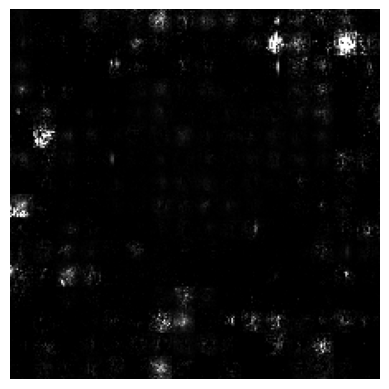

In [20]:
imshow(ig2_mask.mean(-1))